# KNN Classification: Predicting High Financial Aid

## Step 1: Problem Definition

### Question

**Can we predict whether a college provides above-median financial aid based on institutional characteristics?**

### Target Variable
- **high_aid**: Binary variable derived from `aid_value` (1 = average institutional grant aid >= median, 0 = below median)

### Prediction Problem
**Binary Classification** — We will use K-Nearest Neighbors (KNN) to classify institutions as providing high or low financial aid.

### Independent Business Metric
If we can accurately predict which institutions are likely to offer generous financial aid, prospective students and families can prioritize applications to schools where they are more likely to receive substantial aid packages, reducing student debt burden and improving college access.

## Step 2: Data Preparation

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

from data_pipelines import (
    load_csv_data,
    convert_to_categorical,
    collapse_categorical_levels,
    drop_rows_with_missing_target,
    drop_columns,
    fill_numeric_missing_with_median,
    normalize_numeric_features,
    one_hot_encode_categoricals
)

In [2]:
# load data
df = load_csv_data("cc_institution_details.csv")
df.head()

Loaded data from cc_institution_details.csv
Shape: (3798, 63)


,index,unitid,chronname,city,state,level,control,basic,hbcu,flagship,...,vsa_grad_after6_transfer,vsa_grad_elsewhere_after6_transfer,vsa_enroll_after6_transfer,vsa_enroll_elsewhere_after6_transfer,similar,state_sector_ct,carnegie_ct,counted_pct,nicknames,cohort_size
0,0,100654,Alabama A&M University,Normal,Alabama,4-year,Public,Masters Colleges and Universities--larger prog...,X,NaN,...,36.4,5.6,17.2,11.1,232937|100724|405997|113607|139533|144005|2285...,13,386,99.7|07,NaN,882.0
1,1,100663,University of Alabama at Birmingham,Birmingham,Alabama,4-year,Public,Research Universities--very high research acti...,NaN,NaN,...,NaN,NaN,NaN,NaN,196060|180461|201885|145600|209542|236939|1268...,13,106,56.0|07,UAB,1376.0
2,2,100690,Amridge University,Montgomery,Alabama,4-year,Private not-for-profit,Baccalaureate Colleges--Arts & Sciences,NaN,NaN,...,NaN,NaN,NaN,NaN,217925|441511|205124|247825|197647|221856|1353...,16,252,100.0|07,NaN,3.0
3,3,100706,University of Alabama at Huntsville,Huntsville,Alabama,4-year,Public,Research Universities--very high research acti...,NaN,NaN,...,0.0,0.0,0.0,0.0,232186|133881|196103|196413|207388|171128|1900...,13,106,43.1|07,UAH,759.0
4,4,100724,Alabama State University,Montgomery,Alabama,4-year,Public,Masters Colleges and Universities--larger prog...,X,NaN,...,NaN,NaN,NaN,NaN,100654|232937|242617|243197|144005|241739|2354...,13,386,88.0|07,ASU,1351.0


In [3]:
# convert types
categorical_cols = ['state', 'level', 'control', 'basic', 'hbcu', 'flagship']
df = convert_to_categorical(df, categorical_cols)
df.dtypes

Converted 'state' to categorical type
Converted 'level' to categorical type
Converted 'control' to categorical type
Converted 'basic' to categorical type
Converted 'hbcu' to categorical type
Converted 'flagship' to categorical type


index                 int64
unitid                int64
chronname               str
city                    str
state              category
                     ...   
state_sector_ct       int64
carnegie_ct           int64
counted_pct             str
nicknames               str
cohort_size         float64
Length: 63, dtype: object

In [4]:
# collapse categorical levels
df = collapse_categorical_levels(df, 'basic', top_n=5, other_label='Other')
df = collapse_categorical_levels(df, 'state', top_n=10, other_label='Other')

Collapsed 'basic' to top 5 categories + 'Other'
New value counts:
basic
Other                                                 2011
Associates--Private For-profit                         517
Masters Colleges and Universities--larger programs     386
Baccalaureate Colleges--Diverse Fields                 343
Associates--Public Rural-serving Medium                289
Baccalaureate Colleges--Arts & Sciences                252
Name: count, dtype: int64

Collapsed 'state' to top 10 categories + 'Other'
New value counts:
state
Other             1936
California         350
New York           241
Pennsylvania       217
Texas              207
Ohio               185
Florida            176
Illinois           141
North Carolina     135
Georgia            106
Virginia           104
Name: count, dtype: int64



In [5]:
# Drop rows where aid_value is missing
df = drop_rows_with_missing_target(df, 'aid_value')

# Create binary target: 1 if aid_value >= median, 0 otherwise
median_aid = df['aid_value'].median()
df['high_aid'] = (df['aid_value'] >= median_aid).astype(int)

print(f"\nMedian financial aid: ${median_aid:,.2f}")
print(f"\nTarget distribution:")
print(df['high_aid'].value_counts())
print(f"\nPrevalence (baseline accuracy): {df['high_aid'].mean():.4f}")

Dropped 1 rows with missing 'aid_value'
Remaining rows: 3797

Median financial aid: $5,207.00

Target distribution:
high_aid
1    1900
0    1897
Name: count, dtype: int64

Prevalence (baseline accuracy): 0.5004


In [6]:
# Drop unnecessary columns
# Drop identifiers, location, text fields
cols_to_drop = [
    'index', 'unitid', 'chronname', 'city', 'site', 'long_x', 'lat_y',
    'similar', 'nicknames', 'counted_pct', 'cohort_size'
]

# Drop VSA columns 
vsa_cols = [col for col in df.columns if col.startswith('vsa_')]
cols_to_drop.extend(vsa_cols)

# Drop leakage columns: aid_value (source of target) and aid_percentile (derived from it)
cols_to_drop.extend(['aid_value', 'aid_percentile'])

df = drop_columns(df, cols_to_drop)
print(f"\nRemaining columns: {df.columns.tolist()}")

Dropped 30 columns: ['index', 'unitid', 'chronname', 'city', 'site', 'long_x', 'lat_y', 'similar', 'nicknames', 'counted_pct', 'cohort_size', 'vsa_year', 'vsa_grad_after4_first', 'vsa_grad_elsewhere_after4_first', 'vsa_enroll_after4_first', 'vsa_enroll_elsewhere_after4_first', 'vsa_grad_after6_first', 'vsa_grad_elsewhere_after6_first', 'vsa_enroll_after6_first', 'vsa_enroll_elsewhere_after6_first', 'vsa_grad_after4_transfer', 'vsa_grad_elsewhere_after4_transfer', 'vsa_enroll_after4_transfer', 'vsa_enroll_elsewhere_after4_transfer', 'vsa_grad_after6_transfer', 'vsa_grad_elsewhere_after6_transfer', 'vsa_enroll_after6_transfer', 'vsa_enroll_elsewhere_after6_transfer', 'aid_value', 'aid_percentile']
Remaining columns: 34

Remaining columns: ['state', 'level', 'control', 'basic', 'hbcu', 'flagship', 'student_count', 'awards_per_value', 'awards_per_state_value', 'awards_per_natl_value', 'exp_award_value', 'exp_award_state_value', 'exp_award_natl_value', 'exp_award_percentile', 'ft_pct', 'fte

In [7]:
# fill missing vals with median
df = fill_numeric_missing_with_median(df)

Filled 4 missing values in 'ft_pct' with median: 77.0
Filled 2460 missing values in 'med_sat_value' with median: 1040.0
Filled 2460 missing values in 'med_sat_percentile' with median: 49.0
Filled 1474 missing values in 'endow_value' with median: 5466.0
Filled 1474 missing values in 'endow_percentile' with median: 50.0
Filled 331 missing values in 'grad_100_value' with median: 22.5
Filled 331 missing values in 'grad_100_percentile' with median: 46.0
Filled 331 missing values in 'grad_150_value' with median: 41.1
Filled 331 missing values in 'grad_150_percentile' with median: 49.0
Filled 263 missing values in 'retain_value' with median: 66.9
Filled 263 missing values in 'retain_percentile' with median: 49.0
Filled 12 missing values in 'ft_fac_value' with median: 41.5
Filled 12 missing values in 'ft_fac_percentile' with median: 50.0


In [8]:
df = normalize_numeric_features(df, exclude_cols=['high_aid'])

Normalized 27 numeric columns
Excluded from normalization: ['high_aid']


In [9]:
df = one_hot_encode_categoricals(df, drop_first=False)


One-hot encoded 6 categorical columns
Shape change: (3797, 34) -> (3797, 52)


In [10]:
prevalence = df['high_aid'].mean()
baseline_accuracy = max(prevalence, 1 - prevalence)
print(f"Prevalence of high_aid=1: {prevalence:.4f}")
print(f"Baseline accuracy (always predict majority class): {baseline_accuracy:.4f}")
print(f"\nClass distribution:")
print(df['high_aid'].value_counts())

Prevalence of high_aid=1: 0.5004
Baseline accuracy (always predict majority class): 0.5004

Class distribution:
high_aid
1    1900
0    1897
Name: count, dtype: int64


### Train/Tune/Test Split (70/15/15)

In [11]:
# Stratified split on the binary target
train_rows = int(0.7 * len(df))

# First split: Train vs (Tune + Test)
Train, temp = train_test_split(df, train_size=train_rows,
                                stratify=df['high_aid'], random_state=42)

# Second split: Tune vs Test (50/50 of remaining 30%)
tune_ratio = 0.15 / 0.30
Tune, Test = train_test_split(temp, train_size=tune_ratio,
                               stratify=temp['high_aid'], random_state=42)

print(f"Data Split:")
print(f"  Train: {Train.shape} ({len(Train)/len(df)*100:.1f}%)")
print(f"  Tune:  {Tune.shape} ({len(Tune)/len(df)*100:.1f}%)")
print(f"  Test:  {Test.shape} ({len(Test)/len(df)*100:.1f}%)")

print(f"\nClass proportions (high_aid=1):")
print(f"  Train: {Train['high_aid'].mean():.4f}")
print(f"  Tune:  {Tune['high_aid'].mean():.4f}")
print(f"  Test:  {Test['high_aid'].mean():.4f}")

Data Split:
  Train: (2657, 52) (70.0%)
  Tune:  (570, 52) (15.0%)
  Test:  (570, 52) (15.0%)

Class proportions (high_aid=1):
  Train: 0.5006
  Tune:  0.5000
  Test:  0.5000


In [12]:
# Separate features and target
target_col = 'high_aid'

X_train = Train.drop(columns=[target_col])
y_train = Train[target_col]

X_tune = Tune.drop(columns=[target_col])
y_tune = Tune[target_col]

X_test = Test.drop(columns=[target_col])
y_test = Test[target_col]

print(f"Feature count: {X_train.shape[1]}")
print(f"Training samples: {X_train.shape[0]}")

Feature count: 51
Training samples: 2657


## Step 3: KNN Model Building

### Initial Model with k=3
We start with an initial KNN model using k=3 to establish a baseline, then optimize k using the tune set.

In [ ]:
# Initial KNN model with k=3
knn_k3 = KNeighborsClassifier(n_neighbors=3)
knn_k3.fit(X_train, y_train)

y_tune_pred_k3 = knn_k3.predict(X_tune)
y_test_pred_k3 = knn_k3.predict(X_test)

print(f"Initial KNN (k=3) Results:")
print(f"  Tune accuracy:  {accuracy_score(y_tune, y_tune_pred_k3):.4f}")
print(f"  Test accuracy:  {accuracy_score(y_test, y_test_pred_k3):.4f}")
print(f"  Baseline:       {baseline_accuracy:.4f}")

### Selecting Optimal k Using the Tune Set
We train KNN models with different values of k on the training set, then evaluate each on the tune set to find the best k.

In [13]:
# Test odd values of k from 1 to 51 (odd to avoid ties in binary classification)
k_values = list(range(1, 52, 2))
tune_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_tune_pred = knn.predict(X_tune)
    acc = accuracy_score(y_tune, y_tune_pred)
    tune_accuracies.append(acc)

best_idx = np.argmax(tune_accuracies)
best_k = k_values[best_idx]
best_acc = tune_accuracies[best_idx]

print(f"Best k: {best_k}")
print(f"Best tune accuracy: {best_acc:.4f}")

Best k: 13
Best tune accuracy: 0.8333


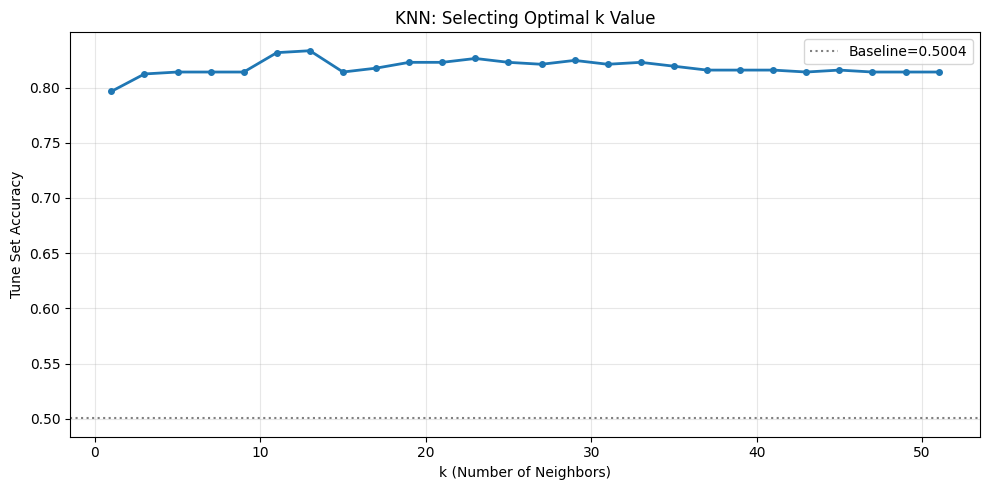

In [14]:
# Visualize k selection
plt.figure(figsize=(10, 5))
plt.plot(k_values, tune_accuracies, marker='o', linewidth=2, markersize=4)
plt.axhline(y=baseline_accuracy, color='gray', linestyle=':', label=f'Baseline={baseline_accuracy:.4f}')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Tune Set Accuracy')
plt.title('KNN: Selecting Optimal k Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
# Train final model with best k and evaluate on test set
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train, y_train)

y_test_pred = knn_final.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Final model (k={best_k}) test accuracy: {test_accuracy:.4f}")
print(f"Baseline accuracy: {baseline_accuracy:.4f}")
print(f"Improvement over baseline: {test_accuracy - baseline_accuracy:.4f}")

Final model (k=13) test accuracy: 0.8456
Baseline accuracy: 0.5004
Improvement over baseline: 0.3452


## Step 4: Threshold Experimentation

KNN's `predict_proba` gives the probability of each class. By default, the threshold is 0.5 (predict class 1 if probability >= 0.5). Adjusting the threshold trades off between precision and recall.

In [16]:
# Get predicted probabilities for the positive class
y_test_proba = knn_final.predict_proba(X_test)[:, 1]

def apply_threshold(probabilities, threshold=0.5):
    """Convert probabilities to binary predictions at a given threshold."""
    return (probabilities >= threshold).astype(int)

# Test a range of thresholds
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

print(f"{'Threshold':<12} {'Accuracy':<12} {'Precision':<12}")

for t in thresholds:
    y_pred_t = apply_threshold(y_test_proba, threshold=t)
    acc = accuracy_score(y_test, y_pred_t)
    prec = precision_score(y_test, y_pred_t, zero_division=0)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t, labels=[0, 1]).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f"{t:<12.1f} {acc:<12.4f} {prec:<12.4f}")


Threshold    Accuracy     Precision   
0.2          0.7632       0.7027      
0.3          0.7860       0.7418      
0.4          0.8298       0.8333      
0.5          0.8456       0.8745      
0.6          0.8386       0.8907      
0.7          0.8263       0.9115      
0.8          0.8193       0.9375      


In [ ]:
# Visual confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels=[0, 1])

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap='Blues')

for i in range(2):
    for j in range(2):
        ax.text(j, i, f"{cm[i, j]}", ha="center", va="center",
                fontsize=16, color="white" if cm[i, j] > cm.max()/2 else "black")

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Low Aid (0)', 'High Aid (1)'])
ax.set_yticklabels(['Low Aid (0)', 'High Aid (1)'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'Confusion Matrix (k={best_k})')
plt.colorbar(im)
plt.tight_layout()
plt.show()

### Reflection

1. **Meaningful Question**: Whether a school offers generous financial aid is directly relevant to students making enrollment decisions and to policymakers evaluating institutional support.
2. **Balanced Classes**: Splitting at the median produces roughly equal class sizes (50/50), meaning the model must demonstrate genuine predictive ability beyond a coin flip.
3. **Feature Set**: Stuff like retention rates, SAT scores, faculty ratios, endowment, and Pell grant percentages are possibly related to aid generosity without being directly derived from it.
4. **Clear Threshold Tradeoffs**: The threshold experimentation reveals interpretable tradeoffs. A lower threshold casts a wider net for students seeking aid, while a higher threshold gives more confident recommendations.

### Concerns

1. **Median Split Sensitivity**: Schools right at the boundary get different labels despite being nearly identical. A school at the 49th and 51st percentile of aid receive opposite labels.
2. **Missing Data Impact**: Some columns had missing values filled with medians. This imputation pushes those values toward the center, potentially reducing the model's ability to distinguish edge cases.
3. **KNN Limitations**: KNN does not provide feature importance, making it harder to explain *why* a school is predicted as high or low aid. It is also sensitive to irrelevant features and the curse of dimensionality with many one-hot encoded columns.